In [1]:
import json
import pandas as pd
import os

json_files_directory = 'json'

# Function to extract data from a single JSON file
def extract_data_from_json(file_path):
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Extract common fields
    publication_id = data.get('id', None)
    journal = data.get('journal', None)
    authors = data.get('authors', [])

    # Initialize containers for title, abstract, and annotations
    title = abstract = None
    genes = []
    drugs = []
    diseases = []

    # Process each passage in the file
    for passage in data.get('passages', []):
        passage_type = passage.get('infons', {}).get('type')
        if passage_type == 'title':
            title = passage.get('text', None)
        elif passage_type == 'abstract':
            abstract = passage.get('text', None)

        # Extracting annotations
        for annotation in passage.get('annotations', []):
            entity_type = annotation.get('infons', {}).get('type')
            if entity_type == 'Gene':
                genes.append(annotation.get('text'))
            elif entity_type == 'Chemical':
                drugs.append(annotation.get('text'))
            elif entity_type == 'Disease':
                diseases.append(annotation.get('text'))

    return {
        'Publication ID': publication_id,
        'Journal': journal,
        'Authors': authors,
        'Title': title,
        'Abstract': abstract,
        'Genes': genes,
        'Drugs': drugs,
        'Diseases': diseases
    }

# Processing all JSON files in the directory
all_data = []
for filename in os.listdir(json_files_directory):
    if filename.endswith('.json'):
        file_path = os.path.join(json_files_directory, filename)
        all_data.append(extract_data_from_json(file_path))

# Convert to DataFrame
df = pd.DataFrame(all_data)

# Save data to a new file in CSV format
csv_output_path = 'extracted_data.csv'
df.to_csv(csv_output_path, index=False)


print(f"Data saved in CSV format at: {csv_output_path}")



Data saved in CSV format at: extracted_data.csv


In [2]:
import pandas as pd
import ast
from nltk.stem import PorterStemmer
import nltk

nltk.download('punkt')

# Initialize stemmer
stemmer = PorterStemmer()

# Function to stem a list of words
def stem_words(word_list):
    stemmed_list = []
    for word in word_list:
        # Stemming
        stemmed = stemmer.stem(word)
        stemmed_list.append(stemmed)
    return stemmed_list

# Load the data from the CSV file
csv_file_path = 'extracted_data.csv'  
df = pd.read_csv(csv_file_path)

# Convert string representations of lists into actual lists
df['Genes'] = df['Genes'].apply(ast.literal_eval)
df['Drugs'] = df['Drugs'].apply(ast.literal_eval)
df['Diseases'] = df['Diseases'].apply(ast.literal_eval)

# Apply stemming to Genes, Drugs, and Diseases columns
df['Genes'] = df['Genes'].apply(stem_words)
df['Drugs'] = df['Drugs'].apply(stem_words)
df['Diseases'] = df['Diseases'].apply(stem_words)

# Save the processed data to a new CSV file
csv_output_path = 'processed_stemmed_data.csv'
df.to_csv(csv_output_path, index=False)


print(f"Data saved in CSV format at: {csv_output_path}")


Data saved in CSV format at: processed_stemmed_data.csv


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Samee\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import ast

# Load the data from the CSV file
csv_file_path = 'processed_stemmed_data.csv'
df = pd.read_csv(csv_file_path)

# Convert string representations of lists into actual lists
df['Genes'] = df['Genes'].apply(ast.literal_eval)
df['Drugs'] = df['Drugs'].apply(ast.literal_eval)
df['Diseases'] = df['Diseases'].apply(ast.literal_eval)

# Filter out non-string and NaN values from 'Diseases'
df['Diseases'] = df['Diseases'].apply(lambda diseases: [d for d in diseases if isinstance(d, str)])

# Entity Analysis
gene_counts = df['Genes'].explode().value_counts()
drug_counts = df['Drugs'].explode().value_counts()
disease_counts = df['Diseases'].explode().value_counts()

print("Entity Analysis Findings:")
print("Top 5 Genes:", gene_counts.head(5))
print("Top 5 Drugs:", drug_counts.head(5))
print("Top 5 Diseases:", disease_counts.head(5))
print("\n")



Entity Analysis Findings:
Top 5 Genes: sod1               42
tdp-43             41
c9orf72            36
nrf2               25
alpha-synuclein    18
Name: Genes, dtype: int64
Top 5 Drugs: edaravon    21
copper      19
lipid       17
ro          17
glutam      15
Name: Drugs, dtype: int64
Top 5 Diseases: neurodegenerative diseas        694
al                              637
amyotrophic lateral sclerosi    298
nd                              146
alzheimer's diseas              141
Name: Diseases, dtype: int64




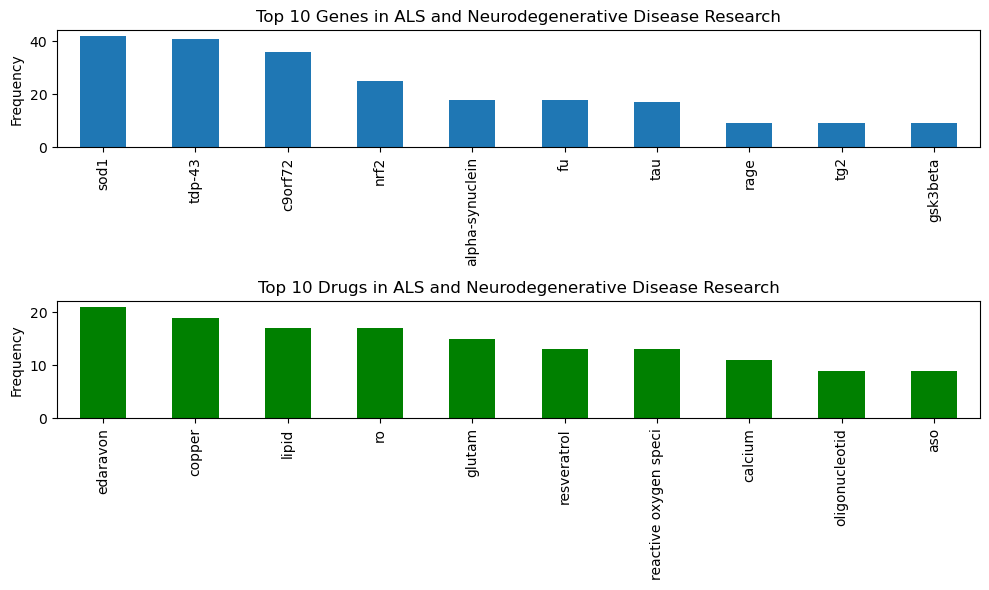

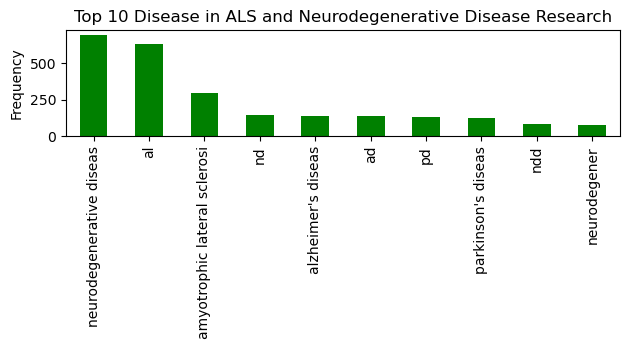

In [35]:
# Trend Analysis                      
# Plotting the most common genes and drugs
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
gene_counts.head(10).plot(kind='bar')
plt.title('Top 10 Genes in ALS and Neurodegenerative Disease Research')
plt.ylabel('Frequency')

plt.subplot(2, 1, 2)
drug_counts.head(10).plot(kind='bar', color='green')
plt.title('Top 10 Drugs in ALS and Neurodegenerative Disease Research')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.subplot(2, 1, 2)
disease_counts.head(10).plot(kind='bar', color='green')
plt.title('Top 10 Disease in ALS and Neurodegenerative Disease Research')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()



In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import ast
from ipywidgets import interact, Dropdown



csv_file_path = 'processed_stemmed_data.csv'
df = pd.read_csv(csv_file_path)



# Function to draw network graph for a selected disease
def draw_network_graph(selected_disease):
    # Filter the dataframe for the selected disease
    filtered_df = df[df['Diseases'].apply(lambda x: selected_disease in x)]

    # Building the graph
    G = nx.Graph()
    for _, row in filtered_df.iterrows():
        for drug in row['Drugs']:
            for gene in row['Genes']:
                G.add_edge(drug, gene)

    # Drawing the graph
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, k=0.15, iterations=20)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
    plt.title(f'Network Graph for {selected_disease}')
    plt.show()

# Dropdown widget for disease selection
diseases = sorted(set([d for sublist in df['Diseases'].tolist() for d in sublist]))
disease_dropdown = Dropdown(options=diseases)

# Interactive widget
interact(draw_network_graph, selected_disease=disease_dropdown)



interactive(children=(Dropdown(description='selected_disease', options=(' ', '"', '&', "'", '(', ')', ',', '-'…

<function __main__.draw_network_graph(selected_disease)>

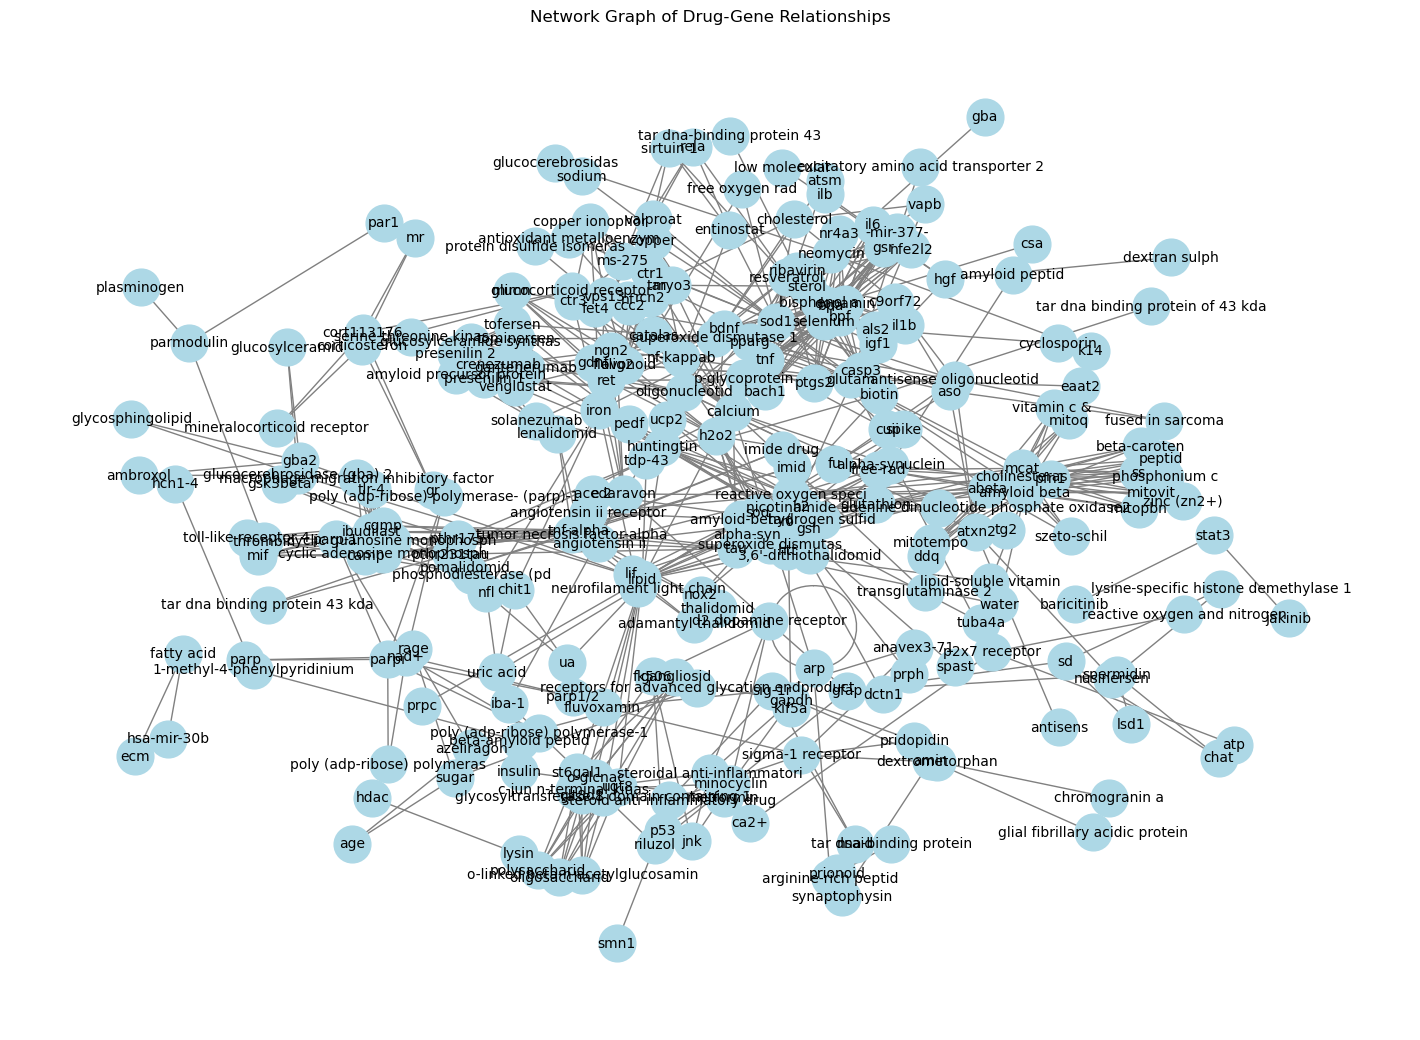

Relationship Mapping Findings:
Number of nodes in the graph: 266
Number of edges in the graph: 616

Note: Each node represents a gene or a drug, and each edge represents a relationship between a gene and a drug.


In [6]:
# Relationship Mapping
# Building a basic network graph between drugs and genes
G = nx.Graph()
for _, row in df.iterrows():
    for drug in row['Drugs']:
        for gene in row['Genes']:
            if drug and gene:  # Ensure that both drug and gene are not empty
                G.add_edge(drug, gene)

# Using spring layout for better node distribution
pos = nx.spring_layout(G, k=0.15, iterations=20)

# Drawing the network graph with adjusted settings
plt.figure(figsize=(14, 10))
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=700, font_size=10)
plt.title('Network Graph of Drug-Gene Relationships')
plt.show()

# Printing findings for Relationship Mapping
print("Relationship Mapping Findings:")
print(f"Number of nodes in the graph: {G.number_of_nodes()}")
print(f"Number of edges in the graph: {G.number_of_edges()}")
print("\nNote: Each node represents a gene or a drug, and each edge represents a relationship between a gene and a drug.")

In [9]:
import pandas as pd
import itertools
import random
import numpy as np
import ast
import gensim
from tensorflow.keras.layers import Input, Dense, Subtract
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Load the dataset
file_path = 'processed_stemmed_data.csv'  
data = pd.read_csv(file_path)

# Function to extract entities
def extract_entities(data):
    genes = set(itertools.chain(*data['Genes'].apply(ast.literal_eval)))
    drugs = set(itertools.chain(*data['Drugs'].apply(ast.literal_eval)))
    diseases = set(itertools.chain(*data['Diseases'].apply(ast.literal_eval)))
    return genes, drugs, diseases

# Function to create pairs
def create_pairs(entities):
    genes, drugs, diseases = entities
    similar_pairs = [(x, y, 1) for x in genes for y in genes if x != y] + \
                    [(x, y, 1) for x in drugs for y in drugs if x != y] + \
                    [(x, y, 1) for x in diseases for y in diseases if x != y]
    not_similar_pairs = [(x, y, 0) for x in genes for y in drugs] + \
                        [(x, y, 0) for x in genes for y in diseases] + \
                        [(x, y, 0) for x in drugs for y in diseases]
    all_pairs = similar_pairs + not_similar_pairs
    random.shuffle(all_pairs)
    return all_pairs

# Extract entities and create pairs
entities = extract_entities(data)
pairs = create_pairs(entities)

# Load the pre-trained Word2Vec model
model = gensim.models.KeyedVectors.load_word2vec_format('glove/GoogleNews-vectors-negative300.bin', binary=True)

# Function to get word embeddings
def get_embedding(word, model):
    try:
        return model[word]
    except KeyError:
        return np.zeros(model.vector_size)

# Prepare data for the Siamese network
def prepare_data(pairs, embedding_model):
    x = np.array([[get_embedding(pair[0], embedding_model), get_embedding(pair[1], embedding_model)] for pair in pairs])
    y = np.array([label for _, _, label in pairs])
    return x, y

# Prepare the data
x, y = prepare_data(pairs, model)
print(len(pairs))
# Siamese Network Definition
def create_siamese_network(input_shape):
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    shared_layer = Dense(128, activation='relu')
    encoded_l = shared_layer(left_input)
    encoded_r = shared_layer(right_input)
    subtracted = Subtract()([encoded_l, encoded_r])
    prediction = Dense(1, activation='sigmoid')(subtracted)
    siamese_net = Model(inputs=[left_input, right_input], outputs=prediction)
    return siamese_net

input_shape = (300,)  # Word2Vec vector size
siamese_network = create_siamese_network(input_shape)
siamese_network.compile(loss="binary_crossentropy", optimizer=Adam(0.0001))

# Split the data
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)





568471



In [10]:
# Train the model
history = siamese_network.fit([x_train[:, 0], x_train[:, 1]], y_train,
                              validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
                              batch_size=128, epochs=10)



Epoch 1/10

3553/3553 [==============================] - 8s 2ms/step - loss: 0.6725 - val_loss: 0.6641
Epoch 2/10
3553/3553 [==============================] - 6s 2ms/step - loss: 0.6639 - val_loss: 0.6623
Epoch 3/10
3553/3553 [==============================] - 6s 2ms/step - loss: 0.6629 - val_loss: 0.6618
Epoch 4/10
3553/3553 [==============================] - 6s 2ms/step - loss: 0.6627 - val_loss: 0.6617
Epoch 5/10
3553/3553 [==============================] - 6s 2ms/step - loss: 0.6626 - val_loss: 0.6616
Epoch 6/10
3553/3553 [==============================] - 6s 2ms/step - loss: 0.6625 - val_loss: 0.6616
Epoch 7/10
3553/3553 [==============================] - 6s 2ms/step - loss: 0.6625 - val_loss: 0.6614
Epoch 8/10
3553/3553 [==============================] - 6s 2ms/step - loss: 0.6625 - val_loss: 0.6615
Epoch 9/10
3553/3553 [==============================] - 6s 2ms/step - loss: 0.6625 - val_loss: 0.6617
Epoch 10/10
3553/3553 [==============================] - 6s 2ms/step - loss: 0.66

In [11]:
# Predicting similarity scores for all pairs
predictions = siamese_network.predict([x[:, 0], x[:, 1]])

# Define the similarity threshold
similarity_threshold = 0.8  # can be adjust as needed

# Mark rows as duplicates or not based on predictions
duplicate_flags = [pred[0] > similarity_threshold for pred in predictions]

# Filter the original DataFrame to exclude duplicates
filtered_data = data[~pd.Series(duplicate_flags)]
print(len(filtered_data))
# Additional filter for ALS-related data
als_related_data = filtered_data[filtered_data['Diseases'].apply(lambda diseases: any('amyotrophic lateral sclerosis' in d.lower() for d in ast.literal_eval(diseases)))]

# Save the ALS-related and deduplicated data to a new CSV file
als_csv_path = 'als_deduplicated_data.csv'  
als_related_data.to_csv(als_csv_path, index=False)

17765/17765 [==============================] - 15s 817us/step
298


C:\Users\Samee\AppData\Local\Temp\ipykernel_1648\4053777481.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_data = data[~pd.Series(duplicate_flags)]


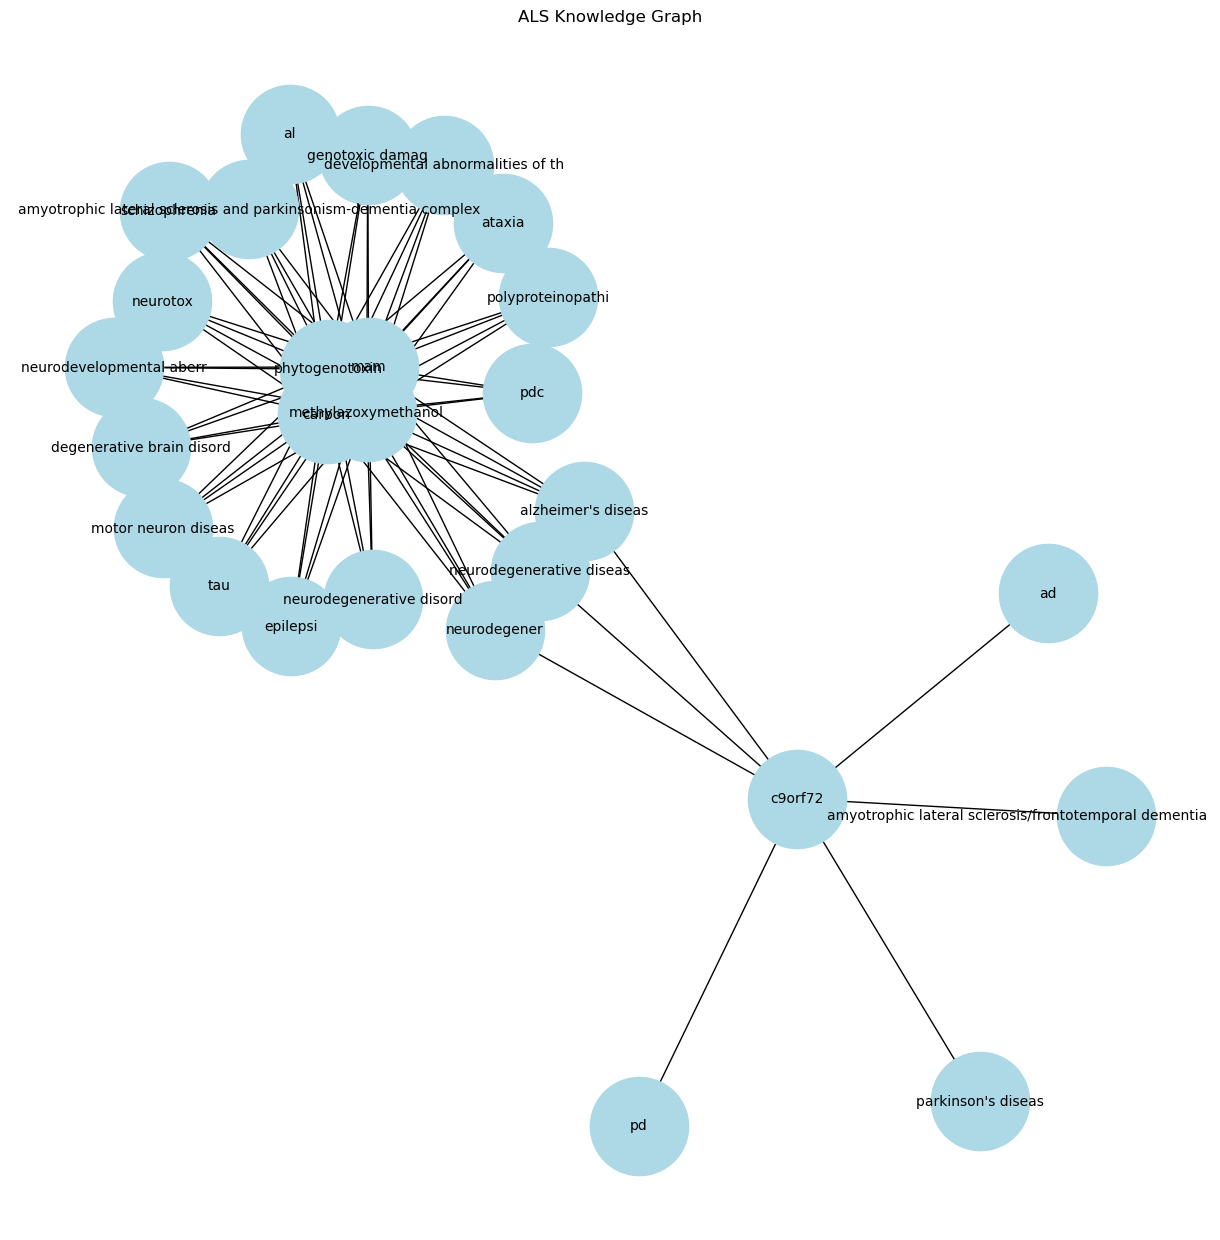

In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import ast

# Load the processed dataset
df = pd.read_csv('als_deduplicated_data.csv')

# Convert string representations of lists into actual lists
df['Genes'] = df['Genes'].apply(ast.literal_eval)
df['Drugs'] = df['Drugs'].apply(ast.literal_eval)
df['Diseases'] = df['Diseases'].apply(ast.literal_eval)

# Filter for ALS-Related Data
als_df = df[df['Diseases'].apply(lambda diseases: any('amyotrophic lateral sclerosis' in d.lower() for d in diseases))]

# Initialize the Knowledge Graph
G = nx.Graph()

# Extracting gene-disease and drug-disease relationships
for _, row in als_df.iterrows():
    for gene in row['Genes']:
        for disease in row['Diseases']:
            # Adding an edge between gene and disease
            G.add_edge(gene, disease, relationship='gene_disease')

    for drug in row['Drugs']:
        for disease in row['Diseases']:
            # Adding an edge between drug and disease
            G.add_edge(drug, disease, relationship='drug_disease')

# Visualization
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)  # Optional layout configuration
nx.draw(G, with_labels=True, node_size=5000, node_color='lightblue', font_size=10, pos=pos)
plt.title('ALS Knowledge Graph')
plt.show()


# Entity Merging: As mentioned in the research document, the entity merging procedure should be a three step process which includes entity canonicalization, duplicate detection, and then finally the merging of entities. Here

In [25]:
# Updating the code as per the new requirement

import pandas as pd
import ast

def parse_and_canonicalize(column):
    """
    Parse the string representation of lists in the column, 
    canonicalize (convert to lowercase and strip spaces), 
    and remove duplicates for each record.
    """
    canonicalized_data = []
    for item in column:
        # Convert string representation of list to actual list
        entities = ast.literal_eval(item)
        # Canonicalize and remove duplicates
        unique_entities = set(entity.lower().strip() for entity in entities)
        canonicalized_data.append(unique_entities)
    return canonicalized_data

def create_entity_csv(data, entity_column, output_file_path):
    """
    Create a CSV file with two columns: 'Publication ID' and the specific entity type.
    Each row contains the Publication ID and a unique entity associated with it.
    """
    # Flatten the data to have one entity per row with the corresponding publication ID
    flattened_data = []
    for index, row in data.iterrows():
        pub_id = row['Publication ID']
        for entity in row[entity_column]:
            flattened_data.append({'Publication ID': pub_id, entity_column: entity})

    # Creating a DataFrame from the flattened data
    df = pd.DataFrame(flattened_data)
    
    # Removing duplicates
    df = df.drop_duplicates()

    # Saving the DataFrame to a CSV file
    df.to_csv(output_file_path, index=False)

def main(file_path):
    # Load the CSV file
    data = pd.read_csv(file_path)

    # Apply the function to the 'Genes', 'Drugs', and 'Diseases' columns
    data['Genes'] = parse_and_canonicalize(data['Genes'])
    data['Drugs'] = parse_and_canonicalize(data['Drugs'])
    data['Diseases'] = parse_and_canonicalize(data['Diseases'])

    # Creating and saving the CSV files for each entity type
    create_entity_csv(data, 'Genes', 'genes_publication.csv')
    create_entity_csv(data, 'Drugs', 'drugs_publication.csv')
    create_entity_csv(data, 'Diseases', 'diseases_publication.csv')

    print("CSV files with unique entities and Publication IDs have been created.")

# Applying the function to the provided file path
file_path = 'processed_stemmed_data.csv'
main(file_path)


CSV files with unique entities and Publication IDs have been created.


# Relationship Extraction: For this part, I intend to create an ensemble method which is comprised of Stanford OpenIE 

In [20]:
!pip install stanza

import stanza
stanza.install_corenlp()




2023-12-09 02:21:48 WARNING: Directory C:\Users\Samee\stanza_corenlp already exists. Please install CoreNLP to a new directory.


In [10]:
stanza.download('en')

2023-12-09 02:06:40 INFO: Downloading default packages for language: en (English) ...
2023-12-09 02:06:42 INFO: File exists: C:\Users\Samee\stanza_resources\en\default.zip
2023-12-09 02:06:45 INFO: Finished downloading models and saved to C:\Users\Samee\stanza_resources.


In [11]:
!pip install stanford_openie

In [31]:
import subprocess
import os
import signal
import subprocess
import pandas as pd
from stanza.server import CoreNLPClient




    
# Load the CSV files
genes_publication_df = pd.read_csv('genes_publication.csv')
drugs_publication_df = pd.read_csv('drugs_publication.csv')
diseases_publication_df = pd.read_csv('diseases_publication.csv')
processed_stemmed_data_df = pd.read_csv('processed_stemmed_data.csv')


# Function to retrieve abstract text using Publication ID from processed_stemmed_data
def retrieve_abstract_by_id(pub_id):
    match = processed_stemmed_data_df[processed_stemmed_data_df['Publication ID'] == pub_id]
    if not match.empty:
        return match.iloc[0]['Abstract']
    return None


# Combine all unique entities into a single dictionary keyed by Publication ID
publication_entities = {}
for df, entity_column in [(genes_publication_df, 'Genes'), 
                          (drugs_publication_df, 'Drugs'), 
                          (diseases_publication_df, 'Diseases')]:
    for _, row in df.iterrows():
        pub_id = row['Publication ID']
        entities = set(row[entity_column].split(','))  # Use the actual column name for entities
        if pub_id in publication_entities:
            publication_entities[pub_id].update(entities)
        else:
            publication_entities[pub_id] = entities

# Function to extract and filter relationships using Stanford OpenIE

client = CoreNLPClient(annotators=['openie'], memory='4G', be_quiet=True, endpoint=f'http://localhost:8089')
def extract_and_filter_relationships(text, entities, port):
    
    # Ensure the port is free before starting the CoreNLP client
#     kill_process_on_port(port)
    
    ann =  client.annotate(text)

    filtered_relations = []
    for sentence in ann.sentence:
        for triple in sentence.openieTriple:
            if triple.subject in entities or triple.object in entities:
                filtered_relations.append({
                    'subject': triple.subject,
                    'relation': triple.relation,
                    'object': triple.object
                })
    return filtered_relations

port = 8089
# Extract and filter relationships for each abstract using Publication ID
extracted_relationships = {}
relations = []
for pub_id, entities in publication_entities.items():
    abstract_text = retrieve_abstract_by_id(pub_id)
    if abstract_text:  # Ensure that an abstract was found
        relations.extend(extract_and_filter_relationships(abstract_text, entities, port))
        extracted_relationships[pub_id] = relations

# Print the extracted relationships





2023-12-09 02:27:36 INFO: Writing properties to tmp file: corenlp_server-1d4cb30fa819423c.props
2023-12-09 02:27:36 INFO: Starting server with command: java -Xmx4G -cp C:\Users\Samee\stanza_corenlp\* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 8089 -timeout 60000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-1d4cb30fa819423c.props -annotators openie -preload -outputFormat serialized


In [32]:
print(len(relations))


189


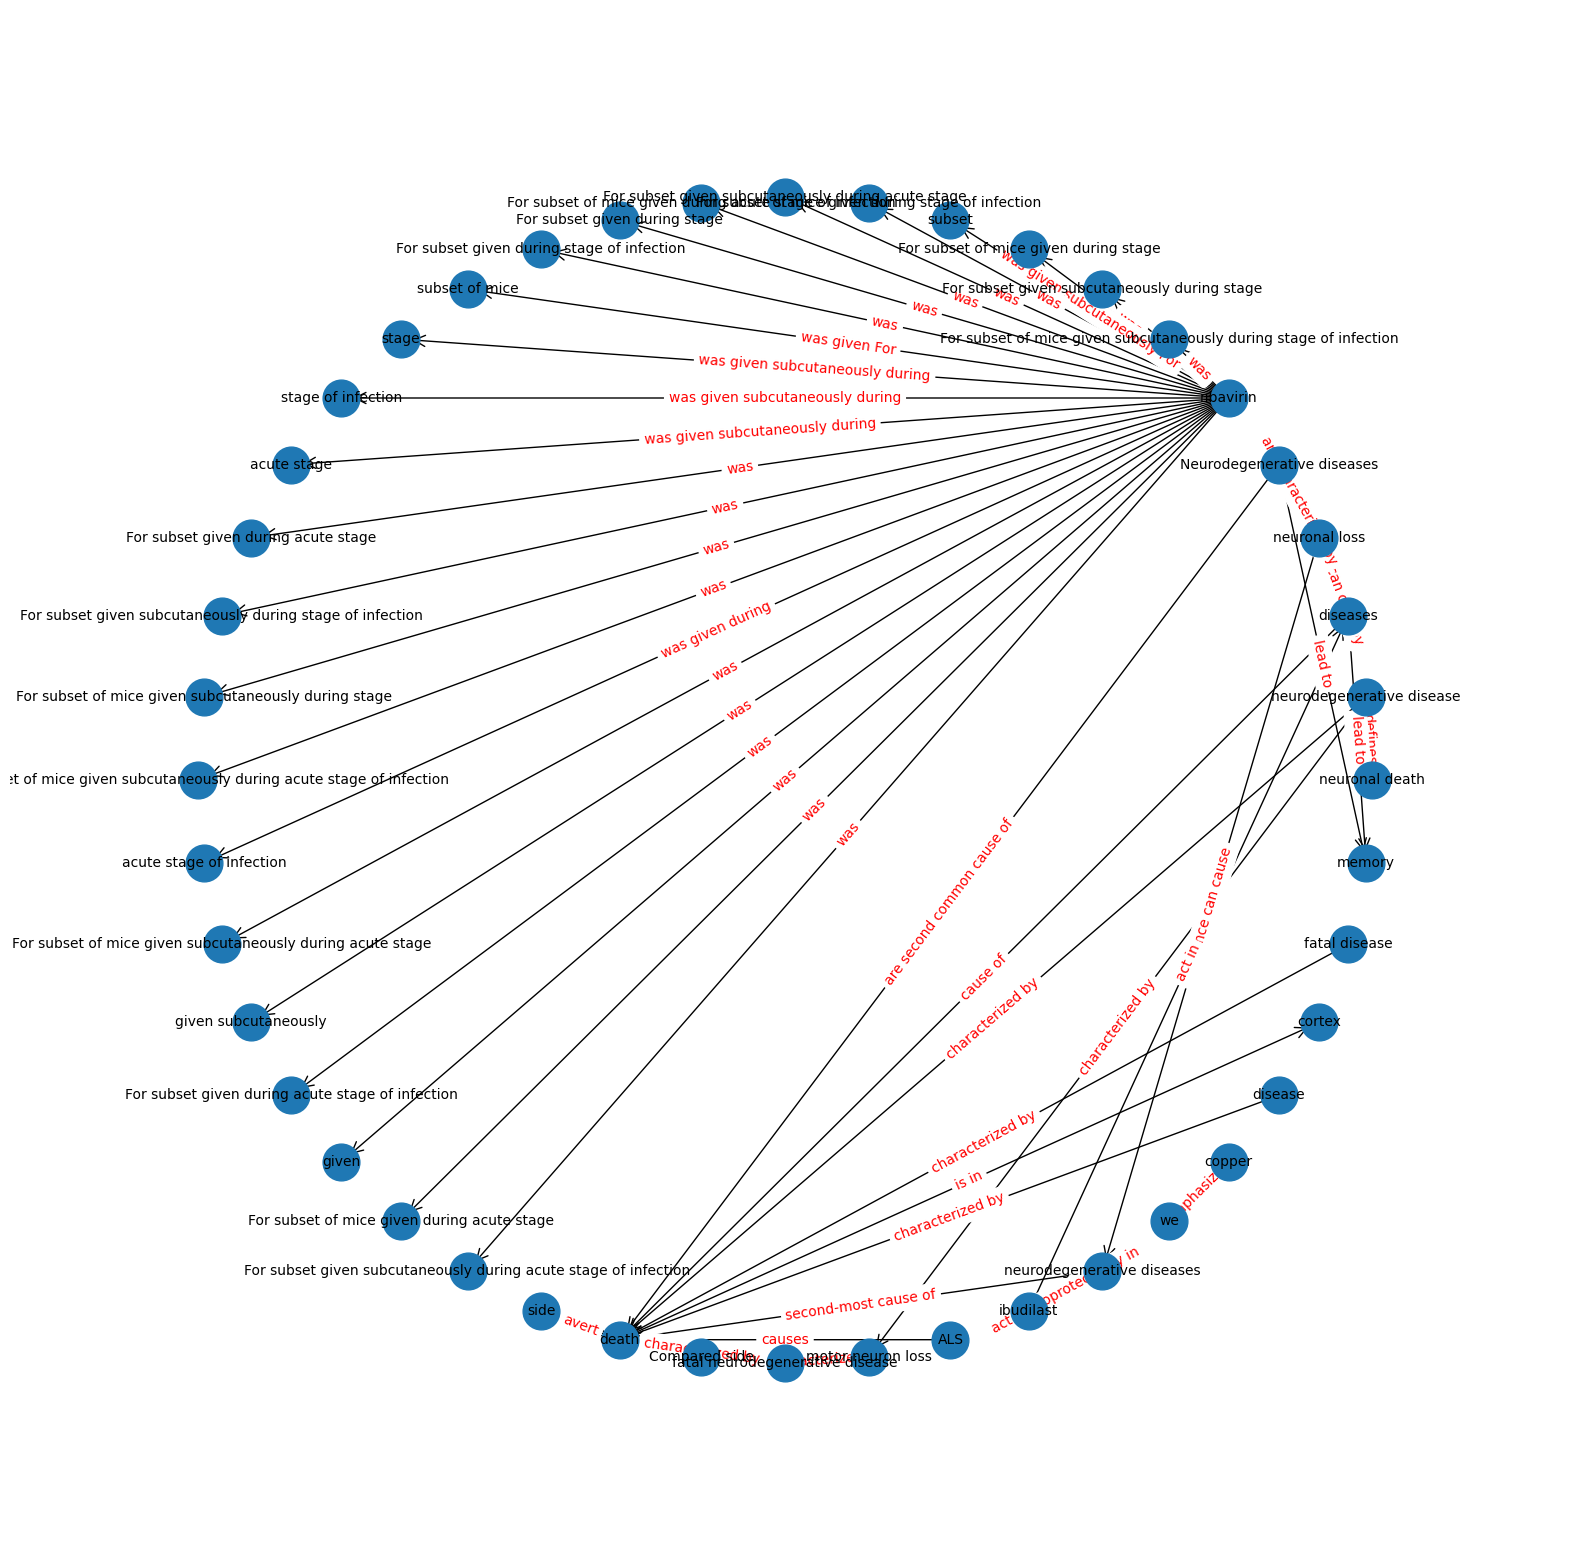

In [52]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming 'relations' is a list of dictionaries, each with 'subject', 'relation', and 'object'
# Example: [{'subject': 'entity1', 'relation': 'related to', 'object': 'entity2'}, ...]

# Create a directed graph
G = nx.DiGraph()

keywords = ["Neurodegenerative diseases", "fatal neurodegenerative disease",  "neurodegenerative disease", "ALS", "death", "neurodegenerative diseases", "diseases", "amyotrophic lateral sclerosis", "tdp-43", "sod1", "c9orf72", "alpha-synuclein", "edaravon", "copper", "al", "alzheimer's diseas", "ribavirin" ]

# Add nodes and edges to the graph
for rel in relations:
    subject = rel['subject']
    obj = rel['object']
    relation = rel['relation']
    if  subject in  keywords or obj in keywords  :
        G.add_node(subject)
        G.add_node(obj)
        G.add_edge(subject, obj, label=relation)

# Set up the figure size
plt.figure(figsize=(20, 20))

# Use circular layout
pos = nx.circular_layout(G)

# Draw the graph
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20)

# Edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')

# Set margins for the axes so that nodes are not cut off
plt.margins(0.1)

# Turn off the axis
plt.axis('off')

# Show the graph
plt.show()
